In [1]:
from IPython.core.magic import register_cell_magic
from IPython.display import HTML, display

def set_background(color):    
    script = (
        "var cell = this.closest('.jp-CodeCell');"
        "var editor = cell.querySelector('.jp-Editor');"
        "editor.style.background='{}';"

    ).format(color)

    display(HTML('<img src onerror="{}">'.format(script)))


In [2]:
#        "this.parentNode.removeChild(this)"

In [3]:
%matplotlib inline

from __future__ import print_function

import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim

import librosa
from IPython.display import Audio, display
from PIL import Image
import matplotlib.pyplot as plt
import scipy.stats as stats

import torchvision.transforms as transforms
import torchvision.models as models
from torch.nn.modules.module import _addindent

import copy
import os
import math

import soundfile as sf
from matplotlib.pyplot import figure

In [4]:
use_cuda = torch.cuda.is_available() #use GPU if available
print('GPU available =',use_cuda)
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

GPU available = True


In [5]:
# set filenames
STYLE_FILENAME = "inputs/lemons.wav" #input filename
outname = 'test' #output dir
runs = 1 # no. of separate outputs (to test consistency), 1 if only want single output

#librosa audio params
N_FFT = 512 
K_HOP = 128 

In [6]:
display(Audio(STYLE_FILENAME))

In [7]:
x, fs  = sf.read(STYLE_FILENAME)
x=np.append(x, np.zeros(K_HOP-np.mod(len(x), K_HOP)))
N_SAMPLES = len(x)
print(f'np.mod(len(x), hop_size) = {np.mod(len(x), K_HOP)}')
print(f' number of hops is {len(x)//K_HOP}')

np.mod(len(x), hop_size) = 0
 number of hops is 1480


<div style="background-color: honeydew">
<h2>First, using checkout standard log STFT </h2>
</div>

R_huz range is [5.759643942684911e-08, 69.97103796951383 ] 
K_HOP - 128 and N_FFT is 512
R shape is (257, 1477)


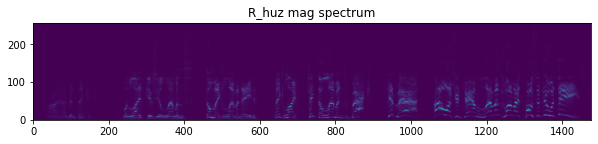

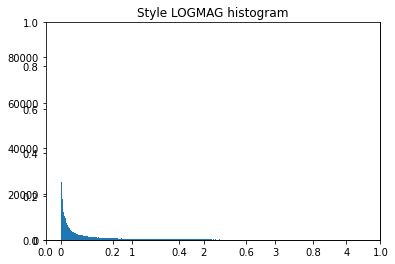

Max bin: 5.759643776817426e-08
Style spectrogram (LOG R_huz) is in : [5.759643776817426e-08, 4.262271877898643 ] 


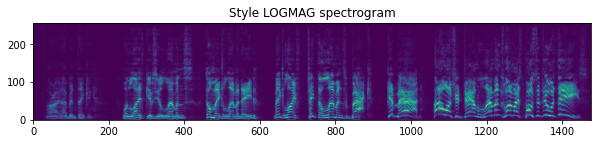

In [8]:
set_background('honeydew')
def log_scale(img):
    img = np.log1p(img)
    return img

def inv_log(img):
    img = np.exp(img) - 1.
    return img

R_huz = np.abs(librosa.stft(x, n_fft=N_FFT, hop_length=K_HOP, win_length=N_FFT,  center=False))
print(f'R_huz range is [{np.amin(R_huz)}, {np.amax(R_huz)} ] ')
print(f'K_HOP - {K_HOP} and N_FFT is {N_FFT}')
print(f'R shape is {R_huz.shape}')

plt.figure(figsize=(10, 5))
plt.title('R_huz mag spectrum')
plt.imshow(R_huz, origin='lower')

a_style_huz = log_scale(R_huz)


"""we plot out the STFT magnitude range and the spectrogram do get a feel of the data"""
#plt.ion()
fig = plt.figure()
plt.title('Style LOGMAG histogram')
ax = fig.add_subplot(111)
n,b,_ = ax.hist(a_style_huz.flatten(),bins='auto')
maxbin = np.argmax(n)
plt.show()
print("Max bin:",b[maxbin])

plt.figure(figsize=(10, 5))
plt.title('Style LOGMAG spectrogram')
plt.imshow(a_style_huz, origin='lower')
print(f"Style spectrogram (LOG R_huz) is in : [{np.amin(a_style_huz)}, {np.amax(a_style_huz)} ] ")

<div style="background-color: #EEEEFF">
<h2>Now with TFRESI </h2>
</div>

In [19]:
set_background('#EEEEFF')

from tifresi.hparams import HParams
from tifresi.stft import GaussTruncTF

from tifresi.transforms import log_spectrogram
from tifresi.transforms import inv_log_spectrogram

#SWITHEROO ON THE LOG FUNCTION!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
log_spectrogram=log_scale
inv_log_spectrogram=inv_log


stft_channels = HParams.stft_channels = N_FFT 
hop_size =  HParams.hop_size  = K_HOP

# For faster processin, a truncated window can be used instead
stft_system = GaussTruncTF(hop_size=hop_size, stft_channels=stft_channels)


R_mari range is [2.431010404045217e-07, 69.0 ] 
K_HOP - 128 and N_FFT is 512
R shape is (257, 1480)


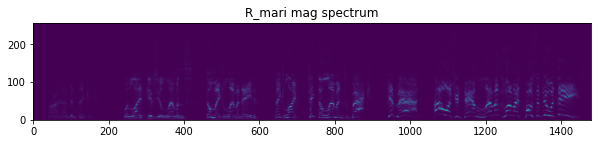

In [24]:
set_background('#EEEEFF')

stft_system = GaussTruncTF(hop_size=hop_size, stft_channels=stft_channels)
R_mari = stft_system.spectrogram(x) * 69
print(f'R_mari range is [{np.amin(R_mari)}, {np.amax(R_mari)} ] ')
print(f'K_HOP - {K_HOP} and N_FFT is {N_FFT}')
print(f'R shape is {R_mari.shape}')

plt.figure(figsize=(10, 5))
plt.title('R_mari mag spectrum')
plt.imshow(R_mari, origin='lower')


Style spectrogram (LOG R_mari) is in : [2.431010108554686e-07, 4.248495242049359 ] 


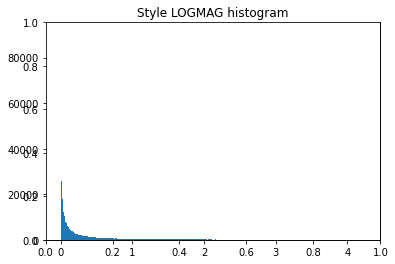

Max bin: 2.431010108554686e-07
Style spectrogram (LOG R_mari) is in : [2.431010108554686e-07, 4.248495242049359 ] 


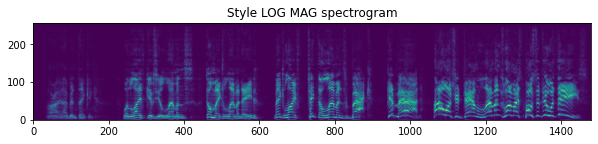

In [25]:
set_background('#EEEEFF')

# Now get the LOG spectrum using TFRESI

a_style_mari=  log_spectrogram(R_mari)
print(f"Style spectrogram (LOG R_mari) is in : [{np.amin(a_style_mari)}, {np.amax(a_style_mari)} ] ")
"""we plot out the STFT magnitude range and the spectrogram do get a feel of the data"""
#plt.ion()
fig = plt.figure()
plt.title('Style LOGMAG histogram')
ax = fig.add_subplot(111)
n,b,_ = ax.hist(a_style_mari.flatten(),bins=100)
maxbin = np.argmax(n)
plt.show()
print("Max bin:",b[maxbin])

plt.figure(figsize=(10, 5))
plt.title('Style LOG MAG spectrogram')
plt.imshow(a_style_mari, origin='lower')
print(f"Style spectrogram (LOG R_mari) is in : [{np.amin(a_style_mari)}, {np.amax(a_style_mari)} ] ")

In [26]:
set_background('#EEEEFF')

#invert the log operation, then construct the time domain signal 

newmag_mari=inv_log_spectrogram(a_style_mari)
new_y_mari = stft_system.invert_spectrogram(newmag_mari)

In [27]:
set_background('#EEEEFF')

display(Audio(new_y_mari, rate=16000))